# Cvičenie 11: Generativne siete

Na dnešnom cvičení si vysvetlíme princíp fungovania dvoch typov generatívnych sietí: **Variatonal Autoencoder** (VAE) a **generatívnych adversiálnych neurónových sietí** (generative adversarial network alebo GAN). GANká sú pomerne nový typ neurónových sietí, ich architektúra bola popísaná v roku 2017.  Oproti tomu VAE bol popisany v roku 2013.  Obe riešia v prvom rade problém generovania nových údajov: teda ak máme k dispozícii trénovacie dáta, dokáže neurónová sieť generovať úplne nové dáta, ktoré sú podobné tým v trénovacej množine. Dnes si vytvorime tieto modely o porovname ich vygenerovane data.

![](https://github.com/DominikVranay/neural-networks-course/blob/master/labs/sources/lab11/11.1-VAE.png?raw=1)

Na dnešnom cvičení implementujeme obe siete v PyTorch a porovname ich data. Kostru riešenia nájdete [tu](https://github.com/DominikVranay/neural-networks-course/blob/3f7c3ca54ca67333af325de680899e368e8e6f9a/labs/sources/lab11/lab11.py).

## 1. Načítanie knižníc, potrebných funkcií a datasetu
V riešení využijeme už známe knižnice `torch`, `numpy` a `matplotlib`. Ako dataset použijeme MNIST dataset, ktorý sme používali už v minulosti

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5), std=(0.5))])
trainset = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=torchvision.transforms.ToTensor())
trainset2 = torchvision.datasets.MNIST('/files/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
trainloader2 = torch.utils.data.DataLoader(trainset2, batch_size=128, shuffle=True)
device = ("cuda:0" if torch.cuda.is_available() else "cpu")

## 2. Definícia autoenkódera VAE

V ďalšom kroku zadefinujeme variačný autoenkóder s jednou skrytou vrstvou.

### 2.1. Definícia modelov encoder a decoder

V tomto kroku zadefinujeme 2 modely: enkóder a dekóder. Každý bude vytvorený pomocou vlastného sekvenčného modela.

In [2]:
class Encoder(nn.Module):
    '''
    simple encoder with a single hidden dense layer (ReLU activation)
    and linear projections to the diag-Gauss parameters
    '''
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(Encoder, self).__init__()
        self.fc = nn.Linear(input_dim, hidden_dim) 
        self.mu = nn.Linear(hidden_dim, embedding_dim) 
        self.sigma = nn.Linear(hidden_dim, embedding_dim) 

    
    def forward(self, x):
        out = self.fc(x)
        out = F.relu(out)
        mu = self.mu(out)
        log_var = self.sigma(out)
        return mu, log_var


class Decoder(nn.Module):
    '''
    simple decoder: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, embedding_dim, dec_hidden_units, image_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, dec_hidden_units) 
        self.fc2 = nn.Linear(dec_hidden_units, image_dim) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)
        return out

### 2.2. Trénovanie VAE

Neostáva nám nič iné, len natrénovať našu sieť. Pridajte chýbajúce parametre do volaní funkcií nasledovne:
* optimizer - napr. adam
* criterion - napr. binary crossentropy
* input - vstup autoenkódera (28x28)
* output - očakávaný výstup autoenkódera (28x28)

Epoch:  0 Loss:  0.246982234906643


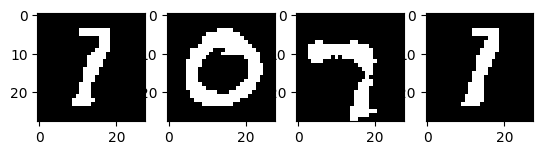

Epoch:  1 Loss:  0.20706657114181112


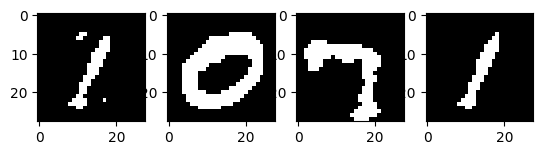

Epoch:  2 Loss:  0.2005455440029185


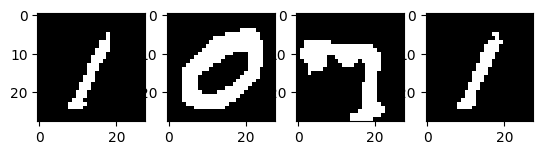

Epoch:  3 Loss:  0.19746985105758016


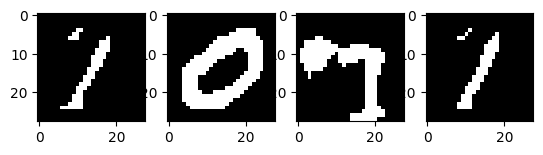

Epoch:  4 Loss:  0.1954744779049082


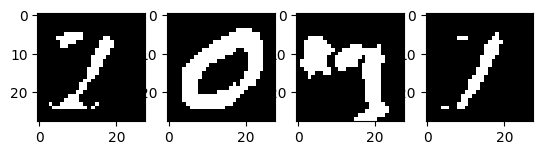

Epoch:  5 Loss:  0.19383713349382928


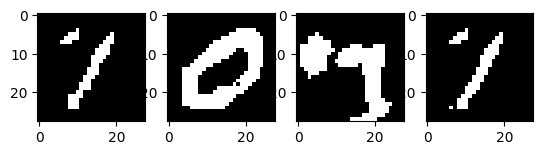

Epoch:  6 Loss:  0.19234784156718152


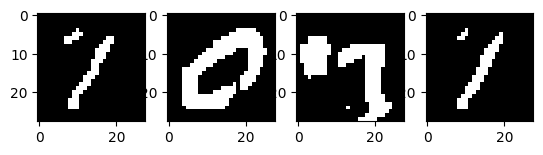

Epoch:  7 Loss:  0.19119110475195214


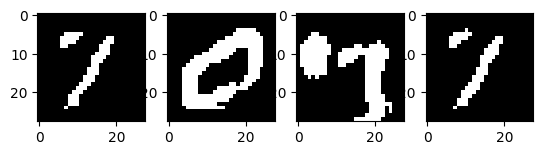

Epoch:  8 Loss:  0.1901578095365078


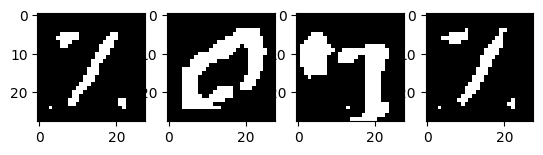

Epoch:  9 Loss:  0.1892699120526618


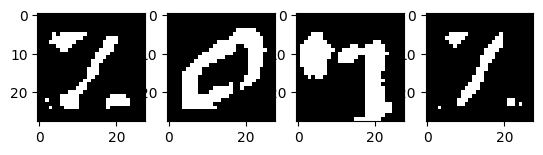

In [3]:
# Sampling function (using the reparameterisation trick)
def sample(mu, log_sigma2):
    eps = torch.randn(mu.shape[0], mu.shape[1]).to(device)
    return mu + torch.exp(log_sigma2 / 2) * eps


#parameters
embedding_dim = 2
enc_hidden_units = 512
dec_hidden_units = 512
image_dim = 28**2
nEpoch = 10

# construct the encoder, decoder and optimiser
enc = Encoder(image_dim, enc_hidden_units, embedding_dim).to(device)
dec = Decoder(embedding_dim, dec_hidden_units, image_dim).to(device)
optimizer = torch.optim.Adam(list(enc.parameters())+ list(dec.parameters()), lr=1e-3)
criterion = torch.nn.BCELoss().to(device)

# training loop
for epoch in range(nEpoch):
    losses = 0
    for inputs, _ in trainloader:
        optimizer.zero_grad()
        inputs = inputs.view(-1, image_dim).to(device)

        mu, log_sigma2 = enc(inputs)
        z = sample(mu, log_sigma2)
        outputs = dec(z)

        # E[log P(X|z)] - as images are binary it makes most sense to use binary cross entropy
        # we need to be a little careful - by default torch averages over every observation 
        # (e.g. each  pixel in each image of each batch), whereas we want the average over entire
        # images instead
        recon = criterion(outputs, inputs)
        
        loss = recon
        loss.backward()
        optimizer.step()

        # keep track of the loss and update the stats
        losses += loss.item()

    print("Epoch: ", epoch, "Loss: ", losses/len(trainloader))
    for i in range(4):
        plt.subplot(141+i)
        a = torch.reshape(trainset.data[i].type(torch.FloatTensor), (1, 784)).to(device)
        mu, log_sigma2 = enc(a)
        z = sample(mu, log_sigma2)
        outputs = dec(z)
        outputs = torch.reshape(outputs, (28, 28)).type(torch.ByteTensor)
        plt.imshow(outputs, cmap=plt.get_cmap('gray'))

    # show the plot
    plt.show()

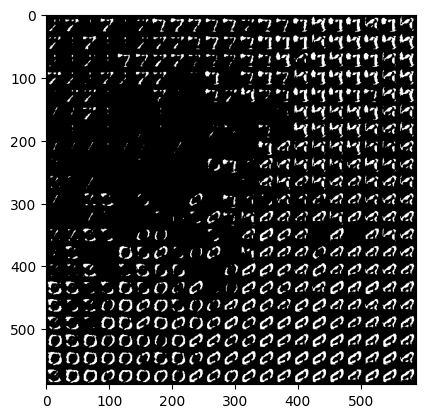

In [4]:
sigma = 20
log_sigma2 = torch.tensor([[torch.log(torch.tensor(sigma**2)), torch.log(torch.tensor(sigma**2))]]).to(device)
img = torch.ByteTensor(588, 588)
for i in range(21):
    for j in range(21):
        mu = torch.tensor([[(-4+i*0.4)*sigma, (4-j*0.4)*sigma]]).to(device)
        z = sample(mu, log_sigma2)
        outputs = dec(z)
        outputs = torch.reshape(outputs, (28, 28)).type(torch.ByteTensor)
        img[28*j:28*(j+1), 28*i:28*(i+1)] = outputs
plt.imshow(img, cmap=plt.get_cmap('gray'))
    # show the plot
plt.show()

## 3. GAN

Úlohou generátora je generovať nové obrázky (alebo iný typ údajov) z náhodného vstupu, t.j. šumu. Vyprodukovaný príklad je potom použitý ako vstup diskriminátora. Diskriminátor má jednu úlohu: zistiť, či vstup je reálny (teda z trénovacej množiny) alebo bol vygenerovaný generátorom - je to jednoduchý binárny klasifikátor. Použitím tejto architektúry nemusíme riešiť spôsob trénovania generátora a diskriminátora osobitne, natrénujeme ich spolu.

![](https://github.com/DominikVranay/neural-networks-course/blob/master/labs/sources/lab11/11.2-GAN.png?raw=1)

In [5]:
class Discriminator(nn.Module):
    '''
    simple Discriminator: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, image_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(image_dim, hidden_dim) 
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) 
        self.fc3 = nn.Linear(hidden_dim, 1) 

    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = torch.sigmoid(out)
        return out


class Generator(nn.Module):
    '''
    simple Generator: single dense hidden layer (ReLU activation) followed by 
    output layer with a sigmoid to squish values
    '''
    def __init__(self, embedding_dim, hidden_dim, image_dim):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, image_dim) 
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = torch.tanh(out)
        return out

### 3.1. Trenovanie GAN

Hlavný problém pri trénovaní generátora osobitne je to, že nemáme k dispozícii očakávané vstupy a výstupy. Vstupný šum vieme vygenerovať náhodne, ale nedokážeme dostať k nemu prislúchajúci očakávaný výstup - z nášho pohľadu vygenerovaný výstup môže byť vhodný pre naše účely alebo len šum podobný vstupu. Teoreticky by sme mohli poprosiť ľudí, aby ohodnotili výstup generátora, či je podľa nich postačujúci alebo nie, ale takýto proces by bol namáhavý a nepraktický. Práve preto pridáme do architektúry diskriminátor, ktorý nahradí takéhoto človeka a naučí sa rozdeliť reálne obrázky od tých generovaných. Oproti človeku má diskriminátor ešte jednu výhodu, t.j. vie konkrétne, ktoré obrázky boli reálne, a ktoré vyprodukované. S takouto architektúrou sú nám známe vstupy aj výstupy:

*   vstupom generátora je náhodne vygenerovaný šum, a výstupom je obrázok;
*   ak diskriminátor dostane na vstupe obrázok z trénovacej množiny, jeho výstupom má byť 1 (reálny obrázok);
*   ak diskriminátor dostane na vstupe obrázok vygenerovaný generátorom, jeho výstupom má byť 0 (fake obrázok).

Práve preto generátor nebudeme trénovať samostatne, ale spojíme ho s diskriminátorom do jednej siete, ktorej vstupom je šum, a očakávaným výstupom je 0 (keďže vždy generujeme fakeový obrázok). Samotný obrázok je skrytý v strede siete ako výstup generátora. Túto architektúru vidíte v dolnej časti obrázka vyššie.

Všeobecne, trénovanie GANiek má nasledujúce kroky:

1.   trénovanie diskriminátora kombinovane s realnymi obrazkami a vygenerovanymi obrazkami
2.   trénovanie generátora s náhodným vstupom a očakávaným výstupom 0 na istom počte príkladov

Kým pri klasifikačných úlohách naším cieľom je maximalizovať presnosť klasifikátora (dosiahnuť 100%), pri GANkách presnosť chceme udržiavať ideálne okolo 50% - diskriminátor v takom prípade sa nevie rozhodnúť, či vidí reálny alebo fakeový obrázok, nemá vyššiu presnosť ako náhodný generátor. Keďže sa jedná o binárnu klasifikáciu, nemôžeme byť spokojní ani s vysokou ani s nízkou presnosťou (pri nízkej presnosti by nám stačilo zmeniť výstup klasifikátora a máme lepší klasifikátor).

Epoch:  0 Accuracy:  0.940525


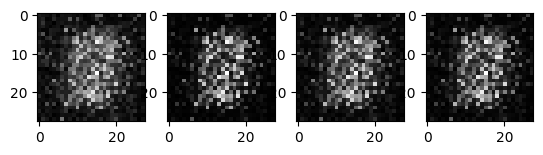

Epoch:  1 Accuracy:  0.863925


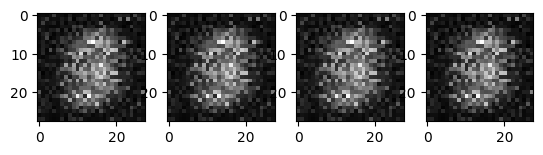

Epoch:  2 Accuracy:  0.8574333333333334


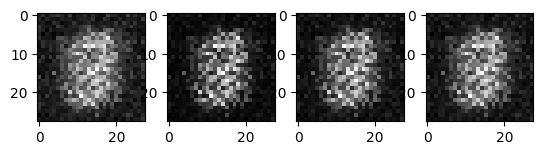

Epoch:  3 Accuracy:  0.8476333333333333


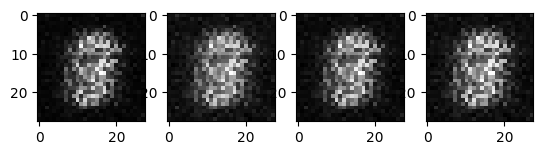

Epoch:  4 Accuracy:  0.91435


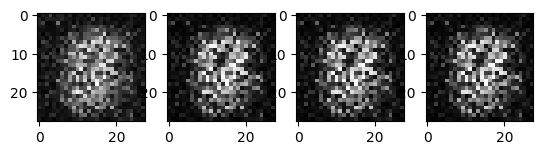

Epoch:  5 Accuracy:  0.874775


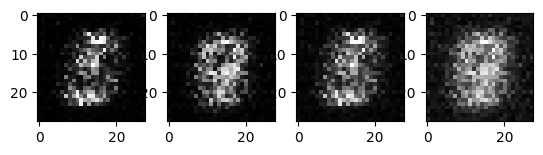

Epoch:  6 Accuracy:  0.8942416666666667


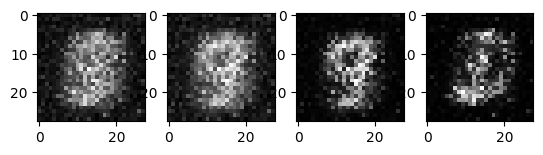

Epoch:  7 Accuracy:  0.8475166666666667


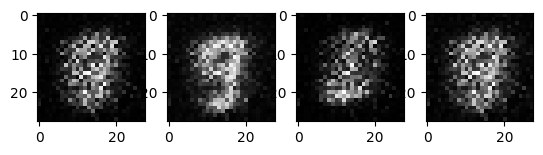

Epoch:  8 Accuracy:  0.9186416666666667


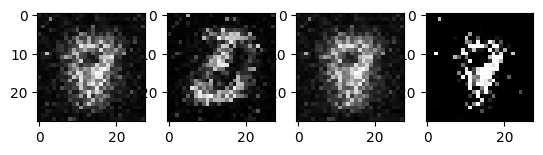

Epoch:  9 Accuracy:  0.92925


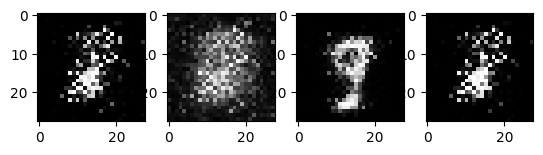

Epoch:  10 Accuracy:  0.8955666666666666


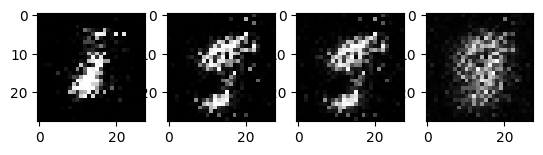

Epoch:  11 Accuracy:  0.907625


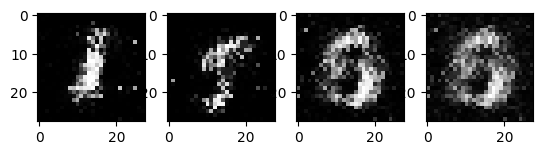

Epoch:  12 Accuracy:  0.91535


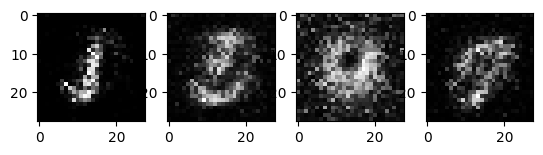

Epoch:  13 Accuracy:  0.8876


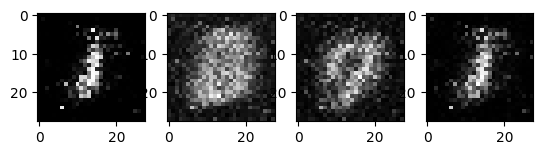

Epoch:  14 Accuracy:  0.8886333333333334


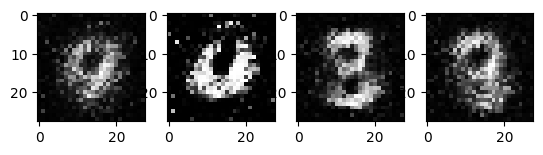

Epoch:  15 Accuracy:  0.9202166666666667


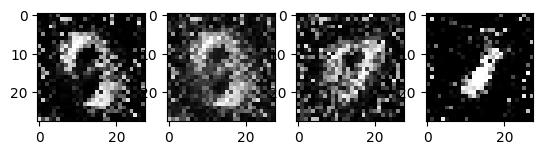

Epoch:  16 Accuracy:  0.925725


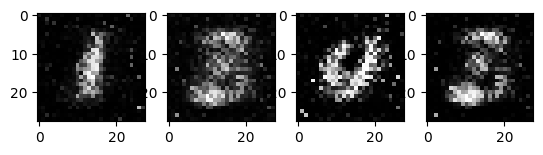

Epoch:  17 Accuracy:  0.9168916666666667


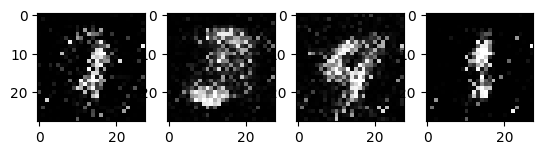

Epoch:  18 Accuracy:  0.9089583333333333


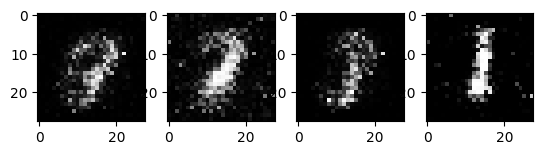

Epoch:  19 Accuracy:  0.9132583333333333


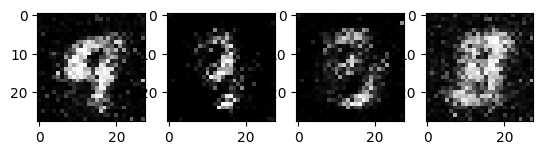

Epoch:  20 Accuracy:  0.9067166666666666


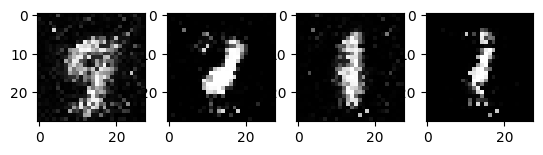

Epoch:  21 Accuracy:  0.9100416666666666


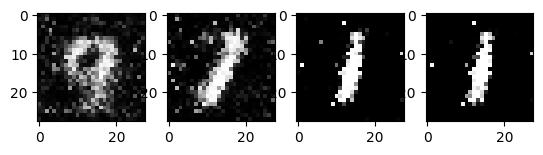

Epoch:  22 Accuracy:  0.91145


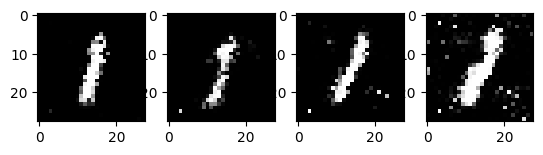

Epoch:  23 Accuracy:  0.9130833333333334


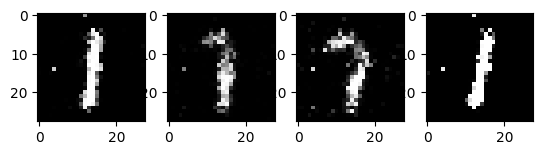

Epoch:  24 Accuracy:  0.9213916666666667


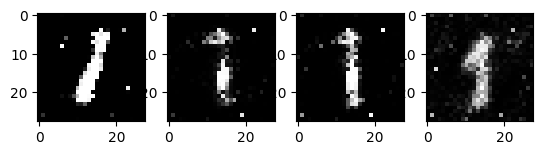

Epoch:  25 Accuracy:  0.9274916666666667


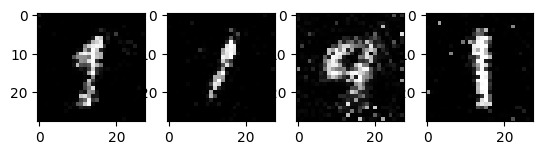

Epoch:  26 Accuracy:  0.9201083333333333


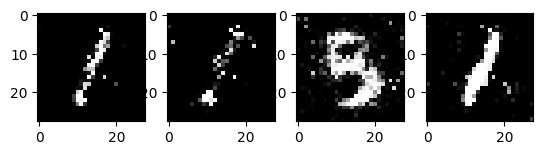

Epoch:  27 Accuracy:  0.9193916666666667


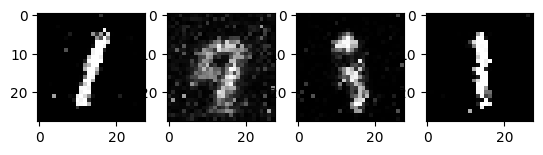

Epoch:  28 Accuracy:  0.9126916666666667


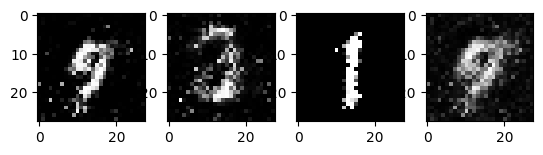

Epoch:  29 Accuracy:  0.905425


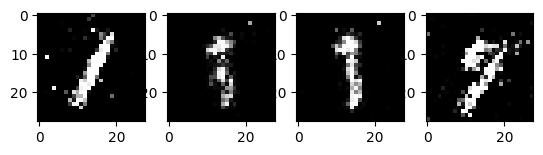

Epoch:  30 Accuracy:  0.903


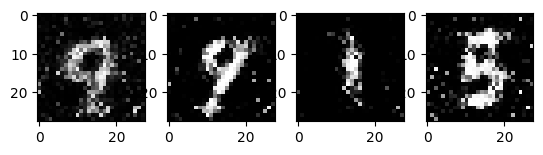

Epoch:  31 Accuracy:  0.9017583333333333


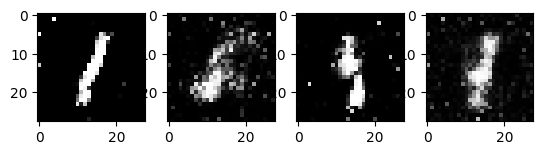

Epoch:  32 Accuracy:  0.893625


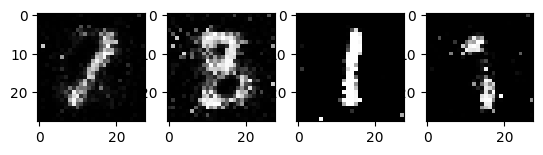

Epoch:  33 Accuracy:  0.88145


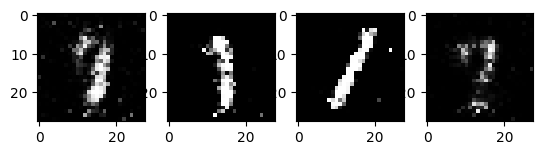

Epoch:  34 Accuracy:  0.8770416666666667


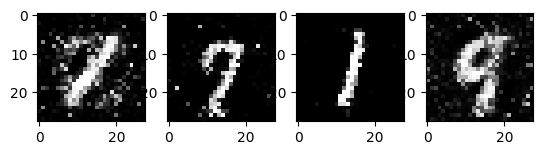

Epoch:  35 Accuracy:  0.8877083333333333


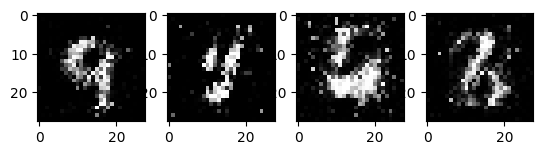

Epoch:  36 Accuracy:  0.8912166666666667


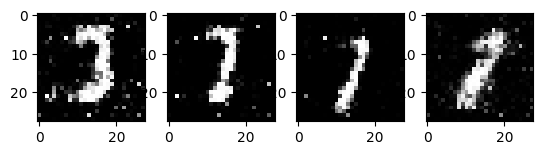

Epoch:  37 Accuracy:  0.8825833333333334


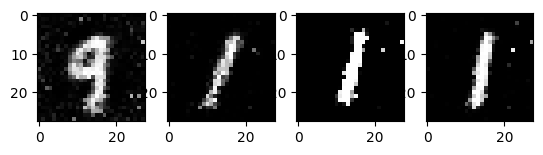

Epoch:  38 Accuracy:  0.8821083333333334


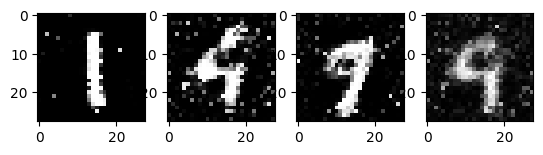

Epoch:  39 Accuracy:  0.8803916666666667


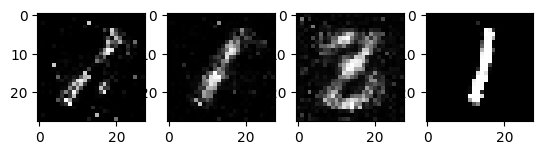

Epoch:  40 Accuracy:  0.8794333333333333


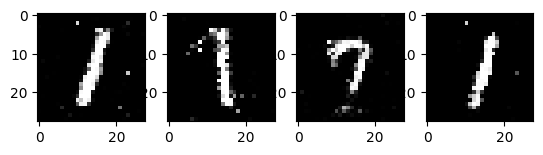

Epoch:  41 Accuracy:  0.885225


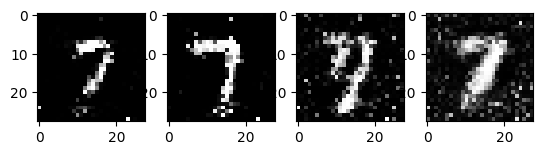

Epoch:  42 Accuracy:  0.8797833333333334


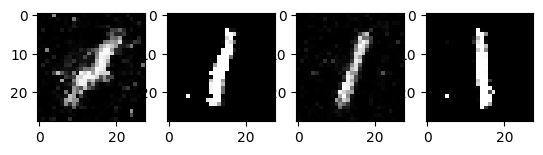

Epoch:  43 Accuracy:  0.873825


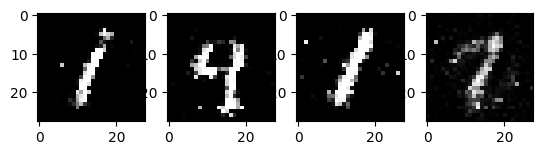

Epoch:  44 Accuracy:  0.8778333333333334


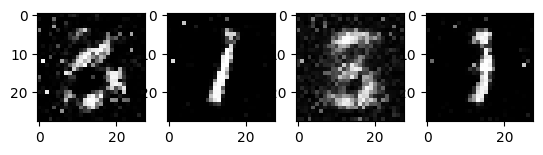

Epoch:  45 Accuracy:  0.8710333333333333


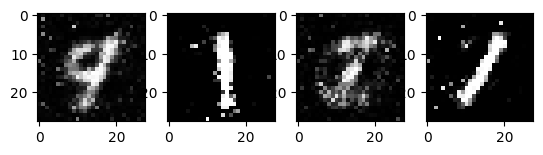

Epoch:  46 Accuracy:  0.87315


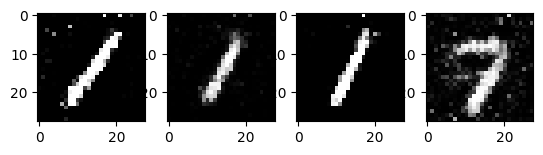

Epoch:  47 Accuracy:  0.8669583333333334


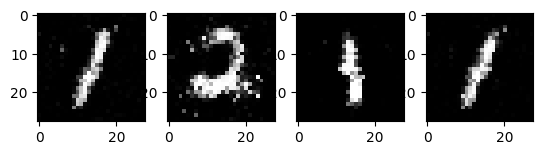

Epoch:  48 Accuracy:  0.8655083333333333


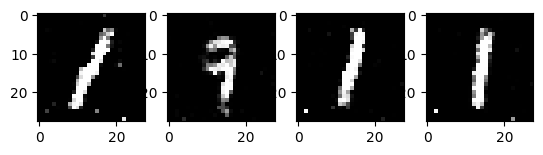

Epoch:  49 Accuracy:  0.8594916666666667


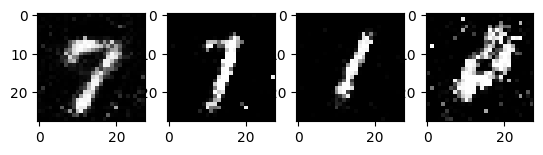

In [6]:
#parameters
embedding_dim = 100
gen_hidden_units = 512
dis_hidden_units = 512
image_dim = 28**2
nEpoch = 50
# construct the encoder, decoder and optimiser
gen = Generator(embedding_dim, gen_hidden_units, image_dim).to(device)
dis = Discriminator(image_dim, dis_hidden_units).to(device)
lr = 0.0002 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=lr)
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=lr)
criterion = torch.nn.BCELoss().to(device)

# training loop
for epoch in range(nEpoch):
    losses_dis = []
    losses_gen = []
    correct = 0
    for inputs, _ in trainloader2:
        batch = len(inputs)
        dis_optimizer.zero_grad()
        inputs = inputs.view(-1, image_dim).to(device)
        gen_inputs = torch.randn(batch, embedding_dim).to(device)
        generated = gen(gen_inputs)
        dis_inputs = torch.cat((inputs, generated), 0)
        outputs = dis(dis_inputs)
        labels = torch.cat((torch.ones(batch, 1), torch.zeros(batch, 1)), 0).to(device)
        correct += (torch.where(abs(outputs-labels)<0.5, 1, 0)).sum().item()
        loss_dis = criterion(outputs, labels)
        loss_dis.backward()
        dis_optimizer.step()

        gen_optimizer.zero_grad()
        gen_inputs = torch.randn(2*batch, embedding_dim).to(device)
        generated = gen(gen_inputs)
        outputs = dis(generated)
        loss_gen = criterion(outputs, torch.ones(2*batch, 1).to(device))
        loss_gen.backward()
        gen_optimizer.step()
        # keep track of the loss and update the stats
        losses_dis.append(loss_dis.item())
        losses_gen.append(loss_gen.item())

    print("Epoch: ", epoch, "Accuracy: ", correct/(len(trainset)*2))
    gen_inputs = torch.randn(4, embedding_dim).to(device)
    generated = gen(gen_inputs)
    for i in range(4):
        plt.subplot(141+i)
        outputs = torch.reshape(generated[i], (28, 28)).detach().cpu().numpy()
        plt.imshow(outputs, cmap=plt.get_cmap('gray'))

    # show the plot
    plt.show()